In [103]:
import tifffile
import numpy as np
import torch
import matplotlib.pyplot as plt
from scipy.interpolate import UnivariateSpline
from scipy import asarray as ar,exp
from scipy.optimize import curve_fit
from scipy import interpolate

In [104]:
def get_projection(img, iso_dimension=-1):
    list_dimensions = [-1, -2, -3]
    list_dimensions.remove(iso_dimension)
    if isinstance(img, np.ndarray):
        img_iso = np.max(img, axis=iso_dimension)
        img_aniso0 = np.max(img, axis=list_dimensions[0])
        img_aniso1 = np.max(img, axis=list_dimensions[1])
    elif isinstance(img, torch.Tensor):
        img_iso = torch.max(img, dim=iso_dimension).values
        img_aniso0 = torch.max(img, dim=list_dimensions[0]).values
        img_aniso1 = torch.max(img, dim=list_dimensions[1]).values
    return img_iso, img_aniso0, img_aniso1


def norm_list(input_list):
    output_list = (input_list - np.min(input_list)) / (np.max(input_list) - np.min(input_list))
    return output_list
def gaussian_fit(list_coor, list_val):

    def gaus(x,a,x0,sigma):
        return a*exp(-(x-x0)**2/(2*sigma**2))

    def getmean_and_sigma(list_coor, list_val):
        x = np.asarray(range(len(list_coor)))
        y = list_val
        mean = sum(x * y)
        sigma = sum(y*(x-mean)**2)/len(list_coor)
        return mean,sigma

    list_val = norm_list(list_val)
    mean, sigma = getmean_and_sigma(list_coor, list_val)
    popt, pcov = curve_fit(gaus, list_coor,list_val,p0=[1, mean, sigma])
    list_val = gaus(list_coor,*popt)
    list_val = norm_list(list_val)

    return list_coor, list_val

def get_listxy(img):

    line_intensity = []
    
    dx = abs(end_x - start_x)
    dy = abs(end_y - start_y)
    sx = 1 if end_x >= start_x else -1
    sy = 1 if end_y >= start_y else -1
    error = dx - dy

    x = start_x
    y = start_y

    while True:
        intensity = img[y][x]  # 获取图像在当前坐标处的强度值
        line_intensity.append(intensity)
        
        if x == end_x and y == end_y:
            break
        
        double_error = 2 * error
        if double_error > -dy:
            error -= dy
            x += sx
        
        if double_error < dx:
            error += dx
            y += sy
    
    list_coor = list(range(0,len(line_intensity)))
    list_val = line_intensity
    return list_coor, list_val

# get_listxy(input_img_aniso0)

In [157]:
def plt_img():
    plt.figure(figsize=(10, 10))
    plt.subplot(211)

    list_x, list_y_input = get_listxy(input_img_aniso0)
    list_y_input = norm_list(list_y_input)
    plt.plot(list_x, list_y_input, color='red', label='input_img_iso')
    # list_x, list_y_input = gaussian_fit(list_x, list_y_input)
    # plt.plot(list_x, list_y_input, color='red', label='input_img_iso_gaussian', linestyle='dashed')

    list_x, list_y_selfnet = get_listxy(selfnet_img_aniso0)
    list_y_selfnet = norm_list(list_y_selfnet)
    plt.plot(list_x, list_y_selfnet, color='blue', label='selfnet_img_iso')
    # list_x, list_y_selfnet = gaussian_fit(list_x, list_y_selfnet)
    # plt.plot(list_x, list_y_selfnet, color='blue', label='selfnet_img_iso', linestyle='dashed')

    list_x, list_y_MPCN = get_listxy(MPCN_img_aniso0)
    list_y_MPCN = norm_list(list_y_MPCN)
    plt.plot(list_x, list_y_MPCN, color='green', label='MPCN_img_iso')
    # list_x, list_y_MPCN = gaussian_fit(list_x, list_y_MPCN)
    # plt.plot(list_x, list_y_MPCN, color='green', label='MPCN_img_iso', linestyle='dashed')

    list_x, list_y_GT = get_listxy(GT_img_aniso0)
    list_y_GT = norm_list(list_y_GT)
    plt.plot(list_x, list_y_GT, color='purple', label='GT_img_iso')
    # list_x, list_y_GT = gaussian_fit(list_x, list_y_GT)
    # plt.plot(list_x, list_y_GT, color='purple', label='GT_img_iso', linestyle='dashed')

    plt.legend()
    plt.xlabel("Distance(μm)")
    plt.ylabel("Normalized intensity")
    plt.show()

    plt.figure(figsize=(10, 10))
    plt.subplot(245)
    plt.imshow(input_img_aniso0, cmap='gray')
    plt.plot([start_x, end_x], [start_y, end_y], color='red', linewidth=1, linestyle='dashed')
    plt.axis('off')
    plt.title('input_img_anisoMIP')

    plt.subplot(246)
    plt.imshow(selfnet_img_aniso0, cmap='gray')
    plt.plot([start_x, end_x], [start_y, end_y], color='red', linewidth=1, linestyle='dashed')
    plt.axis('off')
    plt.title('selfnet_img_anisoMIP')

    plt.subplot(247)
    plt.imshow(MPCN_img_aniso0, cmap='gray')
    plt.plot([start_x, end_x], [start_y, end_y], color='red', linewidth=1, linestyle='dashed')
    plt.axis('off')
    plt.title('MPCN_img_anisoMIP')

    plt.subplot(248)
    plt.imshow(GT_img_aniso0, cmap='gray')
    plt.plot([start_x, end_x], [start_y, end_y], color='red', linewidth=1, linestyle='dashed')
    plt.axis('off')
    plt.title('GT_img_anisoMIP')

In [158]:
input_img = tifffile.imread('./dataset/img_simulation/input0064.tif')[:,40:85,:] # .transpose(1,0,2)
selfnet_img = tifffile.imread('./dataset/img_simulation/selfnet0064.tif')[:,40:85,:]
MPCN_img = tifffile.imread('./dataset/img_simulation/MPCN0064.tif')[:,40:85,:]
GT_img = tifffile.imread('./dataset/img_simulation/GT0064.tif')[:,40:85,:]

plt.figure(figsize=(10, 10))
input_img_iso, input_img_aniso0, input_img_aniso1 = get_projection(input_img)
selfnet_img_iso, selfnet_img_aniso0, selfnet_img_aniso1 = get_projection(selfnet_img)
MPCN_img_iso, MPCN_img_aniso0, MPCN_img_aniso1 = get_projection(MPCN_img)
GT_img_iso, GT_img_aniso0, GT_img_aniso1 = get_projection(GT_img)

<Figure size 1000x1000 with 0 Axes>

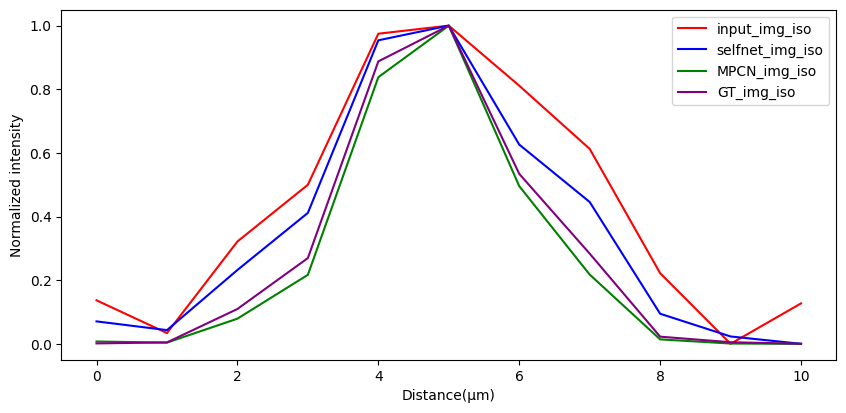

In [159]:
start_x = 65
start_y = 40

end_x = 75
end_y = 35

# 也需要一个多级norm函数
plt_img()

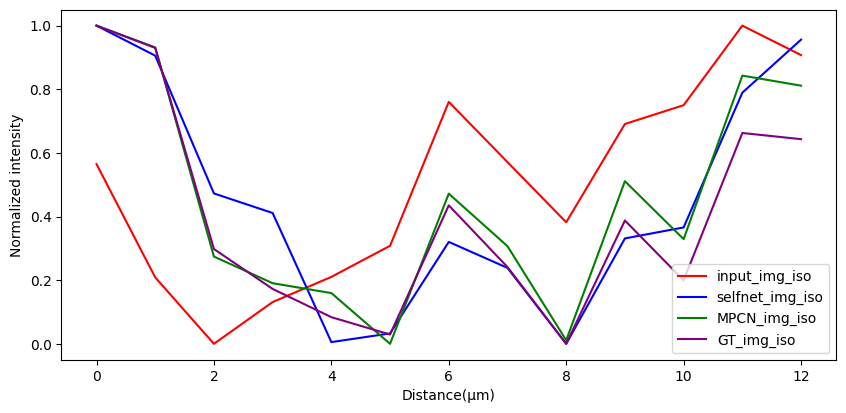

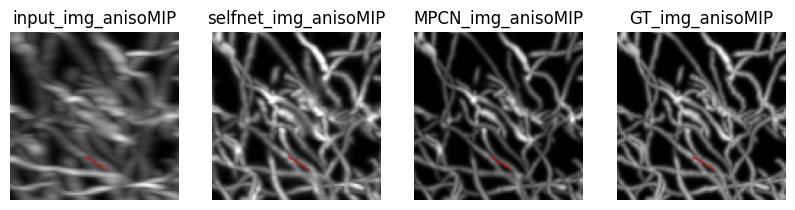

In [138]:
start_x = 43
start_y = 71

end_x = 55
end_y = 78

# 也需要一个多级norm函数
plt_img()

稠密数据 多峰强度图绘制

In [131]:
GT_img = tifffile.imread('./dataset/img_simulation_dense/GT0523.tif')[:,16:61,:]
input_img = tifffile.imread('./dataset/img_simulation_dense/input0523.tif')[:,16:61,:]
MPCN_img = tifffile.imread('./dataset/img_simulation_dense/MPCN0523.tif')[:,16:61,:]
selfnet_img = tifffile.imread('./dataset/img_simulation_dense/selfnet0523.tif')[:,16:61,:]

FileNotFoundError: [Errno 2] No such file or directory: '/home/wangwb/workspace/sr_3dunet/scripts/get_paper_picture/dataset/img_simulation_dense/MPCN0523.tif'

In [ ]:
plt.figure(figsize=(5, 5))

GT_img_iso, GT_img_aniso0, GT_img_aniso1 = get_projection(GT_img)
input_img_iso, input_img_aniso0, input_img_aniso1 = get_projection(input_img)
MPCN_img_iso, MPCN_img_aniso0, MPCN_img_aniso1 = get_projection(MPCN_img)
selfnet_img_iso, selfnet_img_aniso0, selfnet_img_aniso1 = get_projection(selfnet_img)

# start_x = 0
# start_y = 67
# len_ = 37

start_x = 73
start_y = 74
len_ = 26

def norm_list(input_list):
    output_list = (input_list - np.min(input_list)) / (np.max(input_list) - np.min(input_list))
    return output_list

def get_listxy(img):
    list_coor = list(range(0,len_))
    list_val = img[start_y, start_x:start_x+len_]
    return list_coor, list_val

def plt_img():
    plt.figure(figsize=(10, 10))

    plt.subplot(211)
    list_x, list_y_input = get_listxy(input_img_aniso0)
    list_y_input = norm_list(list_y_input)
    plt.plot(list_x, list_y_input, color='red', label='input_img_iso')
    
    list_x, list_y_input = get_listxy(MPCN_img_aniso0)
    list_y_input = norm_list(list_y_input)
    plt.plot(list_x, list_y_input, color='blue', label='MPCN_img_iso')
    
    list_x, list_y_input = get_listxy(GT_img_aniso0)
    list_y_input = norm_list(list_y_input)
    plt.plot(list_x, list_y_input, color='green', label='GT_img_iso')
    
    list_x, list_y_input = get_listxy(selfnet_img_aniso0)
    list_y_input = norm_list(list_y_input)
    plt.plot(list_x, list_y_input, color='purple', label='selfnet_img_iso')

    plt.legend()
    plt.xlabel("Distance(μm)")
    plt.ylabel("Normalized intensity")
    plt.show()

    plt.figure(figsize=(10, 10))
    plt.subplot(245)
    plt.imshow(GT_img_aniso0, cmap='gray')
    plt.plot([start_x, start_x + len_], [start_y, start_y], color='red', linewidth=1, linestyle='dashed')
    plt.axis('off')
    plt.title('GT_img_anisoMIP')
    
    plt.subplot(246)
    plt.imshow(input_img_aniso0, cmap='gray')
    plt.plot([start_x, start_x + len_], [start_y, start_y], color='red', linewidth=1, linestyle='dashed')
    plt.axis('off')
    plt.title('input_img_anisoMIP')
    
    plt.subplot(247)
    plt.imshow(MPCN_img_aniso0, cmap='gray')
    plt.plot([start_x, start_x + len_], [start_y, start_y], color='red', linewidth=1, linestyle='dashed')
    plt.axis('off')
    plt.title('MPCN_img_anisoMIP')
    
    plt.subplot(248)
    plt.imshow(selfnet_img_aniso0, cmap='gray')
    plt.plot([start_x, start_x + len_], [start_y, start_y], color='red', linewidth=1, linestyle='dashed')
    plt.axis('off')
    plt.title('selfnet_img_anisoMIP')


<Figure size 500x500 with 0 Axes>

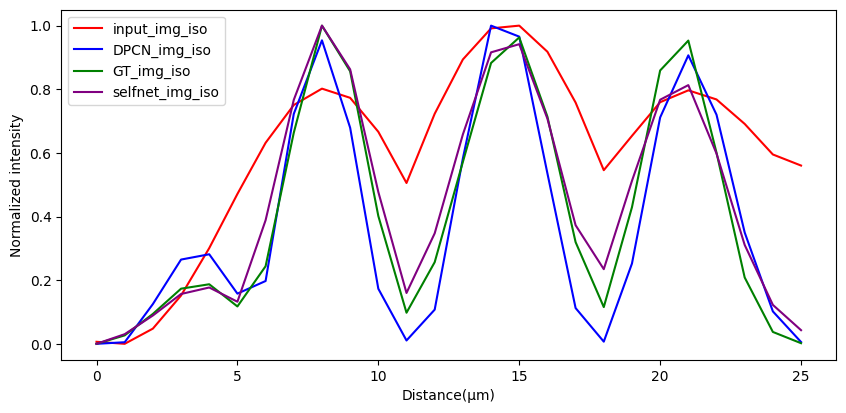

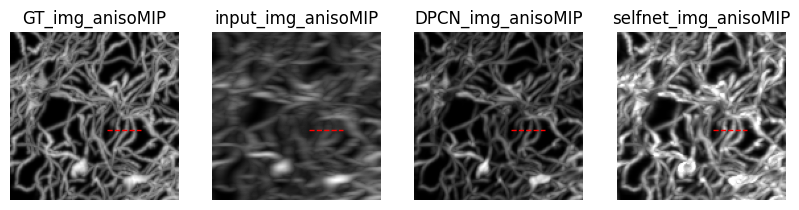

In [ ]:
plt_img()